## 5.2 Training 1 convnet từ đầu với 1 data set nhỏ 

(tl;dr : notebook này ta sẽ train 1 convnet từ đầu với cats & dog data set, notebook sau sẽ train & fine tuning với model VGG16)

---
Trong computer vision, bài toán train 1 model phân loại ảnh với lượng data set nhỏ rất phổ biến. Ở đây, "nhỏ" là từ vài trăm - vài nghìn ảnh. Ta sẽ thực hành bài toán **phân loại chó - mèo**, với 1 data set có 4000 ảnh ( 2000 chó & 2000 mèo). Ta sẽ chia data thành 3 phần : train model với 2000 ảnh, validation 1000 ảnh và test 1000 ảnh . 

Trong mục này, ta sẽ train model từ đầu, bắt đầu với 2000 samples, không sử dụng regularization, độ chính xác của model sau khi train sẽ ~70%. Sau đó ta sẽ học cách sử dụng **data augmentation** --> một kỹ thuật rất mạnh và phổ biến giúp giảm over fitting trong bài toán computer vision. Với **data augmentation**, độ chính xác model sẽ tăng lên ~78%

Mục tiếp theo, ta sẽ thực hành 2 kỹ thuật quan trọng áp dụng trong bài toán deep learning với data set nhỏ : sử dụng trích xuất thuộc tính ( **feature extraction**) với 1 network đã train ( model thu được sẽ có độ chính xác ~90% - 93 %), và **fine-tuning** 1 network đã train (acc ~95%). 3 kĩ năng trên sẽ là các công cụ quan trọng giúp bạn làm các bài toán computer vision sau này.

### 5.2.1 Bài toán với lượng data nhỏ trong deep learning
Bạn có thể sẽ nghĩ rằnng deep learning chỉ hoạt động khi ta có lượng data lớn. Điều này đúng vì 1 đặc điểm quan trọgn của deep learning là model có thể tự tìm ra các thuộc tính quan trọng trong quá trình train mà không cần đến các bước feature-engineering thủ công, nhưng điều đó chỉ có thể làm được khi lượng data lớn, và càng cần thiết hơn trong bài toán khi input là ảnh .

Tuy vậy, 1 yếu tố nữa cũng quan trọng như số samples, đó là độ lớn và sâu của network. Vì convnet học các thuộc tính bao quát và không đổi ( local & translation-invariant features), nó sẽ không cần quá nhiều data cho bài toán nhận diện thuộc tính. Ta có thể xây dựng và train 1 convnet từ đầu, nhưng kết quả cũng không thực sự tốt do thiếu data. --> (notebook này)

Nhưng hơn thế nữa, deep learning models thường được sử dụng với nhiều mục đích. Bạn có thể dùng 1 model chuyển giọng nói thành chữ đã đựợc train với tập data lớn, sau đó tái sử dụng trong bài toán khác với chỉ 1 vài thay đổi nhỏ. Đặc biệt, trong bài toán computer vision, nhiều pretrained-models ( thường được train với [ImageNet dataset](http://www.image-net.org/)) ta có thể download và khởi tạo 1 model mạnh chỉ với rất ít data. Đó là điều ta sẽ thực hành trong mục tiếp theo.

### 5.2.2 Download data

Tập data cats vs. dogs được sử dụng trong 1 cuộc thi trên Kaggle vào năm 2013, khi convnet chưa thực sự phổ biến. [Link download](https://www.kaggle.com/c/dogs-vs-cats/data), bạn cần lập 1 account để tải. 

Không bất ngờ, người chiến thắng của cuộc thi đã sử dụng convnet với acc 95%. Ta cũng có được 1 model với độ chính xác tuơng đương dù lượng data chỉ bằng 1/10 ( chương sau). Dataset ban đầu có 25000 ảnh, với 12500 ảnh mỗi loại, và nặng 543 mb ( đã nén). Sau khi download & giải nén, ta sẽ tạo 1 data set mới gồm 3 phần : tập training( 1000 ảnh mỗi loại), validation (500 ảnh mỗi loài), và test (500 ảnh mỗi loại).

In [1]:
import os, shutil

In [2]:
!ls

cat.png					   Max_Pooling.ipynb
cnn.png					   train
Convolutional_operation.ipynb		   train.zip
Introduction_CNN_with_MNIST_example.ipynb  Untitled.ipynb


In [3]:
# folder chứa data đã giải nén
original_dir = '/home/thanh/Keras-Learning/Chap5-CNN/train'
# folder chứa 4000 ảnh gồm train(2000),valid(1000)và test(1000)
base_dir = '/home/thanh/Keras-Learning/Chap5-CNN/small'
os.mkdir(base_dir)

In [4]:
train_dir = os.path.join(base_dir,'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
os.mkdir(test_dir)

In [5]:
# folder train gồm 2 sub folder : cats và dogs
train_cats_dir = os.path.join(train_dir,'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir,'dogs')
os.mkdir(train_dogs_dir)

In [6]:
# tương tự với folder validation & test
validation_cats_dir = os.path.join(validation_dir,'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir,'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir,'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir,'dogs')
os.mkdir(test_dogs_dir)

In [8]:
# copy 1000 ảnh cat vào train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for filename in fnames:
    src = os.path.join(original_dir,filename)
    dst = os.path.join(train_cats_dir,filename)
    shutil.copyfile(src,dst)

In [9]:
# copy 500 ảnh cat tiếp theo vào validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for filename in fnames:
    src = os.path.join(original_dir,filename)
    dst = os.path.join(validation_cats_dir,filename)
    shutil.copyfile(src,dst)

In [10]:
# copy 500 ảnh test :
fnames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for filename in fnames:
    src = os.path.join(original_dir,filename)
    dst = os.path.join(test_cats_dir,filename)
    shutil.copyfile(src,dst)

In [11]:
# tương tự với dogs :
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for filename in fnames:
    src = os.path.join(original_dir,filename)
    dst = os.path.join(train_dogs_dir,filename)
    shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for filename in fnames:
    src = os.path.join(original_dir,filename)
    dst = os.path.join(validation_dogs_dir,filename)
    shutil.copyfile(src,dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for filename in fnames:
    src = os.path.join(original_dir,filename)
    dst = os.path.join(test_dogs_dir,filename)
    shutil.copyfile(src,dst)

In [12]:
# check lại nào 
def count(folder_name):
    print('total images in ',folder_name,': ',
          len(os.listdir(folder_name)))

In [21]:
count(train_cats_dir)

count(train_dogs_dir)

count(validation_cats_dir)

count(validation_dogs_dir)

count(test_cats_dir)

count(test_dogs_dir)



total images in  /home/thanh/Keras-Learning/Chap5-CNN/small/train/cats :  1000
total images in  /home/thanh/Keras-Learning/Chap5-CNN/small/train/dogs :  1000
total images in  /home/thanh/Keras-Learning/Chap5-CNN/small/validation/cats :  500
total images in  /home/thanh/Keras-Learning/Chap5-CNN/small/validation/dogs :  500
total images in  /home/thanh/Keras-Learning/Chap5-CNN/small/test/cats :  500
total images in  /home/thanh/Keras-Learning/Chap5-CNN/small/test/dogs :  500


Ta đã có 2000 ảnh train, 1000 ảnh validation và 1000 ảnh test. Số lượng ảnh của 2 class là bằng nhau --> Sử dụng accuracy 

### 5.2.3 Xây dựng network

Network của chúng ta sẽ có cấu trúc tương tự ví dụ MNIST trước đó : stack của các Conv2D layers và MaxPooling2D layers.

Tuy vậy, bài toán này phức tạp hơn MNIST với các ảnh lớn hơn, ta sẽ tạo 1 network phù hợp : Network sẽ có nhiều Conv2D + MaxPooling2D hơn. Điều này giúp network hoạt động tốt hơn, cũng như giảm số lượng feature maps trước Flatten layer ( giúp network không quá lớn ). Ở đây, ta bắt đầu với input là ảnh với size khoảng 150x150 , và kết thúc với feature map size 7x7 ( ngay trước Flatten layer)

Lưu ý rằng độ sâu của feature maps dần dần tăng (từ 32 lên 128), trong khi size của feature maps giảm dần (từ 148x148 xuống 7x7). Đây là khuôn mẫu bạn sẽ gặp trong hầu hết các convnets.

Do chúng ta đang làm bài toán binary classification, ta sẽ kết thúc network với 1 con số ( 1 Dense layer với size = 1) và sigmoid activation. Con số này sẽ tượng trưng cho sự lựa chọn class của network

In [22]:
from keras import layers
from keras import models

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu',
                       input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Trong bước compilation, ta sẽ sử dụng RMSprop optimizers như thường lệ. Vì network kết thúc = 1 con số ( sigmoid ), ta sẽ sử dụng binary cross entropy loss function.

In [25]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['acc'])

### Data preprocessing
Như bạn đã biết, data nên được format về dạng tensor (floating point) phù hợp trước khi đưa vào network. Hiện tại, data của chúng ta đang ở dạng JPEG, ta cần phải làm các bước sau :
- Đọc file ảnh
- Giải mã ảnh JPEG sang những ô pixel vuông RBG
- Chuyển đổi các giá trị trên sang dạng floating point tensor
- Rescale giá trị các pixel (từ 0-255) về khoảng [0,1] (Neural Network hoạt động tốt hơn với các giá trị input nhỏ )

Nó khá là rắc rối, tuy vậy Keras đã có sẵn hàm xử lý bước này : Đó là 1 module giúp xử lý ảnh, nằm trong gói keras.preprocessing.image. Trong đó, nó chứa class ImageDataGenerator giúp ta dễ dàng thiết lập Python tự động chuyển các ảnh trong ổ cứng vào batches của các tensors.

In [26]:
from keras.preprocessing.image import ImageDataGenerator

In [27]:
# Các ảnh sẽ được scale 
train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
for data_batch, labels_batch in train_generator:
    print('data_batch:', data_batch.shape)
    print('labels_batch :',labels_batch.shape)
    break # chỉ xem thông tin trong 1 batch 

data_batch: (32, 150, 150, 3)
labels_batch : (32,)


Output của các generator : Generator tạo 32 ảnh 150x150 RGB với nhau (shape(32,150,150,3)) tương ứng với 32 binary labels (shape (32,)). 32 là số samples trong mỗi batch (batch_size). 
**Lưu ý** : ta sử dụng break ở trên vì các batch được gen ra liên tục từ số ảnh trong ổ folder

Fit model với data sử dụng generator bằng method : 
**fit_generator** - một method tương tự fit **sử dụng với generators**.
Ta cũng có thể truyền vào fit_generator 1 argument là **validation_data**, và argument này cho phép **sử dụng generator** cũng như **tuple của Numpy array**. Nếu bạn truyền generator vào validation_data, generator này sẽ không ngừng tạo các batch validation, vậy nên ta phải **chỉ rõ validation_steps** argument.

In [33]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 69s - loss: 0.6801 - acc: 0.5506 - val_loss: 0.6505 - val_acc: 0.6231
Epoch 2/30
100/100 [==============================] - 50s - loss: 0.6298 - acc: 0.6478 - val_loss: 0.6261 - val_acc: 0.6501
Epoch 3/30
100/100 [==============================] - 49s - loss: 0.5708 - acc: 0.7072 - val_loss: 0.6161 - val_acc: 0.6682
Epoch 4/30
100/100 [==============================] - 49s - loss: 0.5238 - acc: 0.7316 - val_loss: 0.5703 - val_acc: 0.6881
Epoch 5/30
100/100 [==============================] - 49s - loss: 0.4911 - acc: 0.7634 - val_loss: 0.5627 - val_acc: 0.6997
Epoch 6/30
100/100 [==============================] - 49s - loss: 0.4559 - acc: 0.7941 - val_loss: 0.6370 - val_acc: 0.6713
Epoch 7/30
100/100 [==============================] - 49s - loss: 0.4192 - acc: 0.8094 - val_loss: 0.5501 - val_acc: 0.7113
Epoch 8/30
100/100 [==============================] - 49s - loss: 0.3926 - acc: 0.8316 - val_loss: 0.5797 - val_acc: 0.7094
Epoch 9/

In [34]:
model.save('cats_and_dogs_small_1.h5')

In [35]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

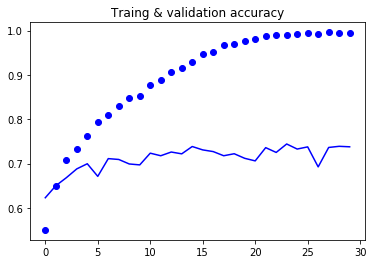

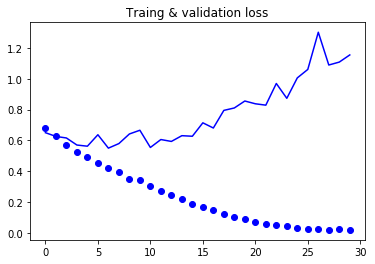

In [36]:
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc,'b')
plt.title('Traing & validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss,'b')
plt.title('Traing & validation loss')

plt.show()

Qua plot ta thấy những đặc điểm của overfitting. Training accuracy tăng liên tục theo thời gian ( ~100%), trong khi validation accuracy chỉ giao động xung quanh 70%. Validation loss chạm min chỉ sau 4 epoch đầu rồi tăng dần. 

Bởi vì giới hạn của tập training (2000 ảnh), over fitting là vấn đề cần quan tâm nhất. Một số phương pháp phổ biến để giảm đỡ over fitting mà ta đã học là drop out và weight decay ( L2 regularization). Trong mục tiếp theo, ta sẽ giới thiệu một phương pháp mới, đặc biệt cho bài toán computer vision và được áp dụng trong bước xử lý ảnh : **data augmentation** 